<a href="https://colab.research.google.com/github/femartinsamorim/programacao-pratica_e_treinamento/blob/main/desafio_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# VERIFICANDO OS DADOS DA GPU

!nvidia-smi

Sun Sep 24 22:40:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# IMPORTAÇÃO DOS PACOTES RAPIDS PARA UTILIZAÇÃO DA GPU:

%%time
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 4.87 MiB/s, done.
Resolving deltas: 100% (191/191), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.6/499.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS NESTE PRIMEIRO MOMENTO

import seaborn as sns
from matplotlib import pyplot as plt
import cudf
import cupy

In [4]:
# CARREGAMENTO DA BASE DE DADOS:

base_dados = cudf.read_csv('/content/Dados para o desafio de classificação.csv')
base_dados.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
# ANALISANDO AS QUANTIDADE DE LINHAS E COLUNAS:

print(f'Quantidade de Linhas: {base_dados.shape[0]} \nQuantidade de Colunas: {base_dados.shape[1]}')

Quantidade de Linhas: 1778649 
Quantidade de Colunas: 11


In [36]:
# IMPORTADANDO MAIS BIBLIOTECAS QUE SERÃO NECESSÁRIAS:

import numpy as np
import warnings as wr
import pandas as pd

wr.filterwarnings('ignore')

In [7]:
# ANALISANDO OS DADOS ESTATÍSTICOS DA BASE DE DADOS:

base_dados.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1778649,1778649,1778648,1778648,1778648,1778648,1778648,1778648
mean,74,162485,857614,878856,995995,1118190,0,0
std,58,269171,2921635,2957777,2305898,2404207,0,0
min,1,0,0,0,0,0,0,0
25%,19,13268,0,0,0,0,0,0
50%,42,79425,15059,0,137932,230443,0,0
75%,137,218723,122777,165425,948010,1158058,0,0
max,162,10000000,38939424,38946233,42207404,42283775,1,0


In [8]:
# ANALISANDO A PORCENTAGEM DE DADOS NULOS:

100 * base_dados.isna().sum()/base_dados.shape[0]

step              0.000000
type              0.000000
amount            0.000000
nameOrig          0.000056
oldbalanceOrg     0.000056
newbalanceOrig    0.000056
nameDest          0.000056
oldbalanceDest    0.000056
newbalanceDest    0.000056
isFraud           0.000056
isFlaggedFraud    0.000056
dtype: float64

In [9]:
# ANALISANDO A QUANTIDADE DE DADOS NULOS:

base_dados.isna().sum()

step              0
type              0
amount            0
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

In [10]:
# OBTEMOS O RETORNO DE APENAS UM REGISTRO NULO PARA 06 ITENS, ABAIXO ESTAREMOS FILTRANDO E ANALISANDO:

base_dados.loc[base_dados['isFraud'].isna()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1778648,162,PAYMENT,22380.24,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [11]:
# IDENTIFICADO A LINHA COM REGISTROS NULOS, REALIZAREI A REMOÇÃO DO DATASET:

base_dados_2 = base_dados.dropna()

print(f'Quantidade de Linhas (Antes): {base_dados.shape[0]} \nQuantidade de Linhas (Depois): {base_dados_2.shape[0]}')

Quantidade de Linhas (Antes): 1778649 
Quantidade de Linhas (Depois): 1778648


In [12]:
# ANALISANDO A QUANTIDADE DE REGISTROS ÚNICOS DAS TABELAS PARA DECIDIR COMO TRATA-LOS:

%%time
print(f'''Step: {base_dados_2["step"].unique().count()}
Type (Tipo Transação): {base_dados_2["type"].unique().count()}
Amount: {base_dados_2["amount"].unique().count()}
NameOrig: {base_dados_2["nameOrig"].unique().count()}
OldbalanceOrg: {base_dados_2["oldbalanceOrg"].unique().count()}
NewbalanceOrig: {base_dados_2["newbalanceOrig"].unique().count()}
NameDest: {base_dados_2["nameDest"].unique().count()}
OldbalanceDest: {base_dados_2["oldbalanceDest"].unique().count()}
NewbalanceDest: {base_dados_2["newbalanceDest"].unique().count()}
IsFraud (Fraude): {base_dados_2["isFraud"].unique().count()}
IsFlaggedFraud: {base_dados_2["isFlaggedFraud"].unique().count()}\n''')

Step: 162
Type (Tipo Transação): 5
Amount: 1678827
NameOrig: 1777913
OldbalanceOrg: 633272
NewbalanceOrig: 772513
NameDest: 754462
OldbalanceDest: 1026978
NewbalanceDest: 857645
IsFraud (Fraude): 2
IsFlaggedFraud: 1

CPU times: user 71.1 ms, sys: 18.9 ms, total: 90 ms
Wall time: 106 ms


In [13]:
#COMO POSSUÍMOS UMA BASE COM MAIS DE 1 MILHÃO DE REGISTROS USAREI UM COMANDO PARA ANALISAR POSSÍVEIS ITENS DUPLICADOS:

%%time
base_dados_2 = base_dados_2.drop_duplicates()

#OBS.: UTILIZAR ESSE PROCEDIMENTO SEM (GPU) PODE LEVAR MUITO MAIS TEMPO, DEVIDO A QUANTIDADE DE REGISTROS.

CPU times: user 26.1 ms, sys: 721 µs, total: 26.8 ms
Wall time: 26.4 ms


In [14]:
# A BASE DE DADOS NÃO POSSUI ITENS DUPLICADOS, APÓS COMANDO RETORNAMOS COM A MESMA QUANTIDADE DE LINHAS:

base_dados_2.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 1778648 entries, 0 to 1778647
Data columns (total 11 columns):
 #   Column          Dtype
---  ------          -----
 0   step            int64
 1   type            object
 2   amount          float64
 3   nameOrig        object
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64
 10  isFlaggedFraud  int64
dtypes: float64(5), int64(3), object(3)
memory usage: 190.6+ MB


 Como não temos mais registros nulos e também não identifiquei necessidade de retirar colunas, seguirei analisando toda base de dados, alterando o nome apenas da variável categorica "type" para facilitar o entendimento e realizando alguns tratamento de normalização dos valores pela função "StandardScaler"

In [15]:
base_dados_2['type'].unique()

0     PAYMENT
1    TRANSFER
2    CASH_OUT
3       DEBIT
4     CASH_IN
Name: type, dtype: object

In [16]:
# RENOMEANDO AS VARIÁVEIS CATEGORIAS REFERENTE AO TIPO DE TRANSAÇÃO:

base_dados_3 = base_dados_2.replace({
    "type":"PAYMENT"},"PAGAMENTO").replace(
    {"type":"TRANSFER"},"TRANSFERENCIA").replace(
    {"type":"CASH_OUT"},"SAQUE").replace(
    {"type":"DEBIT"},"DEBITO").replace(
    {"type":"CASH_IN"},"DINHEIRO")

base_dados_3.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAGAMENTO,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAGAMENTO,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFERENCIA,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,SAQUE,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAGAMENTO,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAGAMENTO,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAGAMENTO,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAGAMENTO,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAGAMENTO,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBITO,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [17]:
base_dados_3['type'].unique()

0        PAGAMENTO
1    TRANSFERENCIA
2            SAQUE
3           DEBITO
4         DINHEIRO
Name: type, dtype: object

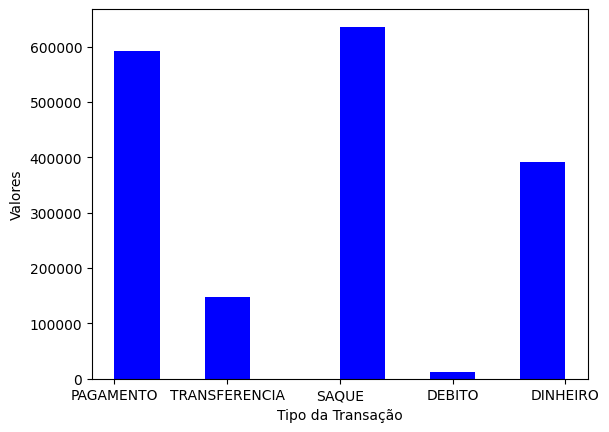

In [18]:
plt.hist(base_dados_3['type'], color='b')
plt.xlabel('Tipo da Transação')
plt.ylabel('Valores')
plt.show()

In [19]:
# REMOVENDO COLUNAS QUE NÃO SERÃO UTILIZADAS:

base_dados_3 = base_dados_3.drop(columns=['nameOrig','nameDest'])

In [20]:
base_dados_3.head(15)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAGAMENTO,9839.64,170136.00,160296.36,0.0,0.00,0,0
1,1,PAGAMENTO,1864.28,21249.00,19384.72,0.0,0.00,0,0
2,1,TRANSFERENCIA,181.00,181.00,0.00,0.0,0.00,1,0
3,1,SAQUE,181.00,181.00,0.00,21182.0,0.00,1,0
4,1,PAGAMENTO,11668.14,41554.00,29885.86,0.0,0.00,0,0
5,1,PAGAMENTO,7817.71,53860.00,46042.29,0.0,0.00,0,0
6,1,PAGAMENTO,7107.77,183195.00,176087.23,0.0,0.00,0,0
7,1,PAGAMENTO,7861.64,176087.23,168225.59,0.0,0.00,0,0
8,1,PAGAMENTO,4024.36,2671.00,0.00,0.0,0.00,0,0
9,1,DEBITO,5337.77,41720.00,36382.23,41898.0,40348.79,0,0


In [35]:
# IMPORTAÇÃO DAS FUNÇÃO PARA TRATAMENTO DOS VALORES E TREINAMENTO DOS MODELOS E GPU:

from cuml.preprocessing import StandardScaler, LabelEncoder, Normalizer
from cuml import train_test_split
from cuml import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
# SEPARAÇÃO DOS DADOS DE TREINO E TESTE:

base_dados_treino = base_dados_3.drop(columns=['isFraud'])
y = base_dados_3['isFraud']

In [23]:
# PROCESSO PARA TRANSFORMAÇÃO DAS VARIÁVEIS CATEGORIAS EM NUMERICA PELO "LABEL-ENCODER":

label_encoder = LabelEncoder()
base_dados_treino['type_encoder'] = label_encoder.fit_transform(base_dados_treino['type'])

base_dados_treino

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_encoder
0,1,PAGAMENTO,9839.64,170136.0,160296.36,0.00,0.00,0,2
1,1,PAGAMENTO,1864.28,21249.0,19384.72,0.00,0.00,0,2
2,1,TRANSFERENCIA,181.00,181.0,0.00,0.00,0.00,0,4
3,1,SAQUE,181.00,181.0,0.00,21182.00,0.00,0,3
4,1,PAGAMENTO,11668.14,41554.0,29885.86,0.00,0.00,0,2
...,...,...,...,...,...,...,...,...,...
1778643,162,SAQUE,167099.19,49961.0,0.00,2444671.16,2611770.35,0,3
1778644,162,SAQUE,372162.46,10555.0,0.00,412302.66,784465.12,0,3
1778645,162,DINHEIRO,98938.21,225828.0,324766.21,7221024.48,7122086.27,0,1
1778646,162,PAGAMENTO,314.95,341.0,26.05,0.00,0.00,0,2


In [24]:
# PROCESSO PARA NORMALIZAÇÃO DOS VALORES DISCREPANTES:

%%time
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(base_dados_treino.amount.values.reshape(1, -1))
base_dados_treino['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = normalizer.fit_transform(base_dados_treino.oldbalanceOrg.values.reshape(1, -1))
base_dados_treino['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = normalizer.fit_transform(base_dados_treino.newbalanceOrig.values.reshape(1, -1))
base_dados_treino['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest = normalizer.fit_transform(base_dados_treino.oldbalanceDest.values.reshape(1, -1))
base_dados_treino['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = normalizer.fit_transform(base_dados_treino.newbalanceDest.values.reshape(1, -1))
base_dados_treino['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

CPU times: user 12.3 s, sys: 367 ms, total: 12.7 s
Wall time: 14.9 s


In [69]:
base_dados_treino.describe().astype(float).round(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_encoder,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
count,1778648.000,1.778648e+06,1.778648e+06,1.778648e+06,1.778648e+06,1.778648e+06,1778648.0,1778648.000,1778648.000,1778648.000,1778648.000,1778648.000,1778648.000
mean,74.463,1.624855e+05,8.576145e+05,8.788562e+05,9.959952e+05,1.118191e+06,0.0,2.291,0.000,0.000,0.000,0.000,0.000
std,58.749,2.691718e+05,2.921635e+06,2.957777e+06,2.305898e+06,2.404208e+06,0.0,0.923,0.001,0.001,0.001,0.001,0.001
min,1.000,6.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,0.000,0.000,0.000,0.000
25%,19.000,1.326806e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.000,0.000,0.000,0.000,0.000,0.000
50%,42.000,7.942528e+04,1.505900e+04,0.000000e+00,1.379321e+05,2.304432e+05,0.0,2.000,0.000,0.000,0.000,0.000,0.000
75%,137.000,2.187240e+05,1.227770e+05,1.654255e+05,9.480102e+05,1.158058e+06,0.0,3.000,0.001,0.000,0.000,0.000,0.000
max,162.000,1.000000e+07,3.893942e+07,3.894623e+07,4.220740e+07,4.228378e+07,0.0,4.000,0.024,0.010,0.009,0.013,0.012


In [73]:
base_dados_treino.iloc[:,7:].head(10)

,isFlaggedFraud,type_encoder,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
0,0,2,2.346578e-05,4.189646e-05,0.000039,0.000000,0.000000
1,0,2,4.445974e-06,5.232625e-06,0.000005,0.000000,0.000000
2,0,4,4.316526e-07,4.457175e-08,0.000000,0.000000,0.000000
3,0,3,4.316526e-07,4.457175e-08,0.000000,0.000006,0.000000
4,0,2,2.782642e-05,1.023279e-05,0.000007,0.000000,0.000000
5,0,2,1.864384e-05,1.326318e-05,0.000011,0.000000,0.000000
6,0,2,1.695076e-05,4.511228e-05,0.000043,0.000000,0.000000
7,0,2,1.874860e-05,4.336197e-05,0.000041,0.000000,0.000000
8,0,2,9.597378e-06,6.577412e-07,0.000000,0.000000,0.000000
9,0,0,1.272963e-05,1.027367e-05,0.000009,0.000013,0.000011


In [26]:
# SEPARAÇÃO DO DADOS DE TREINO:

X = base_dados_treino.iloc[:,7:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.20)

In [27]:
# TREINAMENTO DO MODELO DE REGRESSÃO LOGISTICA:

%%time
clf_logistic_regressor = LogisticRegression()
clf_logistic_regressor.fit(X_train, y_train)
y_pred = clf_logistic_regressor.predict(X_test)

CPU times: user 1.93 s, sys: 700 ms, total: 2.63 s
Wall time: 7.68 s


In [28]:
# METRICAS DE AVALIAÇÃO DO MODELO:

%%time
print("Acurácia: ", accuracy_score(y_test, y_pred))
print("Matriz de confusão: ", confusion_matrix(y_test, y_pred))

Acurácia:  0.998957097530365
Matriz de confusão:  [[355358      0]
 [   371      0]]
CPU times: user 6.7 s, sys: 158 ms, total: 6.86 s
Wall time: 7.91 s


Obtemos uma acurácia alta devido os desbalanceamento dos valores entre Fraude e Não Fraude

In [49]:
# TREINAMENTO DO MODELO RANDOM FOREST:

%%time
clf_random_forest = RandomForestClassifier(n_estimators=5, random_state=42)
clf_random_forest.fit(X_train, y_train)
y_pred = clf_random_forest.predict(X_test)

In [52]:
# METRICAS DE AVALIAÇÃO DO MODELO:

%%time
print("Acurácia: ", accuracy_score(y_test, y_pred))
print("Matriz de confusão: ", confusion_matrix(y_test, y_pred.astype(np.int64)))

Acurácia:  0.9996514320373535
Matriz de confusão:  [[355350      8]
 [   116    255]]
CPU times: user 36.6 ms, sys: 8.86 ms, total: 45.5 ms
Wall time: 46.3 ms


In [68]:
# ANALISANDO A PROBABILIDADE DA CLASSIFICAÇÃO SER UMA FRAUDE (1) OU NÃO (0):

%%time
y_pred_proba = clf_random_forest.predict_proba(X_test)
y_pred_proba

CPU times: user 44.6 ms, sys: 5.76 ms, total: 50.4 ms
Wall time: 83.8 ms


,0,1
418359,1.000000,0.000000
1534085,1.000000,0.000000
110102,1.000000,0.000000
1257253,0.999997,0.000003
1260690,0.999992,0.000008
...,...,...
1030349,0.003158,0.996842
1030331,0.442623,0.557377
1030766,0.993402,0.006598
999453,0.003158,0.996842
